In [12]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from utilities import PA_FULL, PA_GROUPS, PA_OBJECTS, VAR_GROUPS  # noqa: F401

warnings.filterwarnings('ignore')


In [13]:
# Load the data
df = pd.read_csv('data/dataset.csv')
key = pd.read_csv('data/key.csv')


In [14]:
# Select relevant columns for clustering
clustering_columns = [
    # *PA_OBJECTS,
    # *PA_FULL,
    *PA_GROUPS,
    'object_phrases',
    'total_tablecloths',
    'total_bedsheets',
    'total_tunics',
    'faith',
    'gender',
    'wealth_points',
]
data_for_clustering = df[clustering_columns].fillna(0)

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_for_clustering)


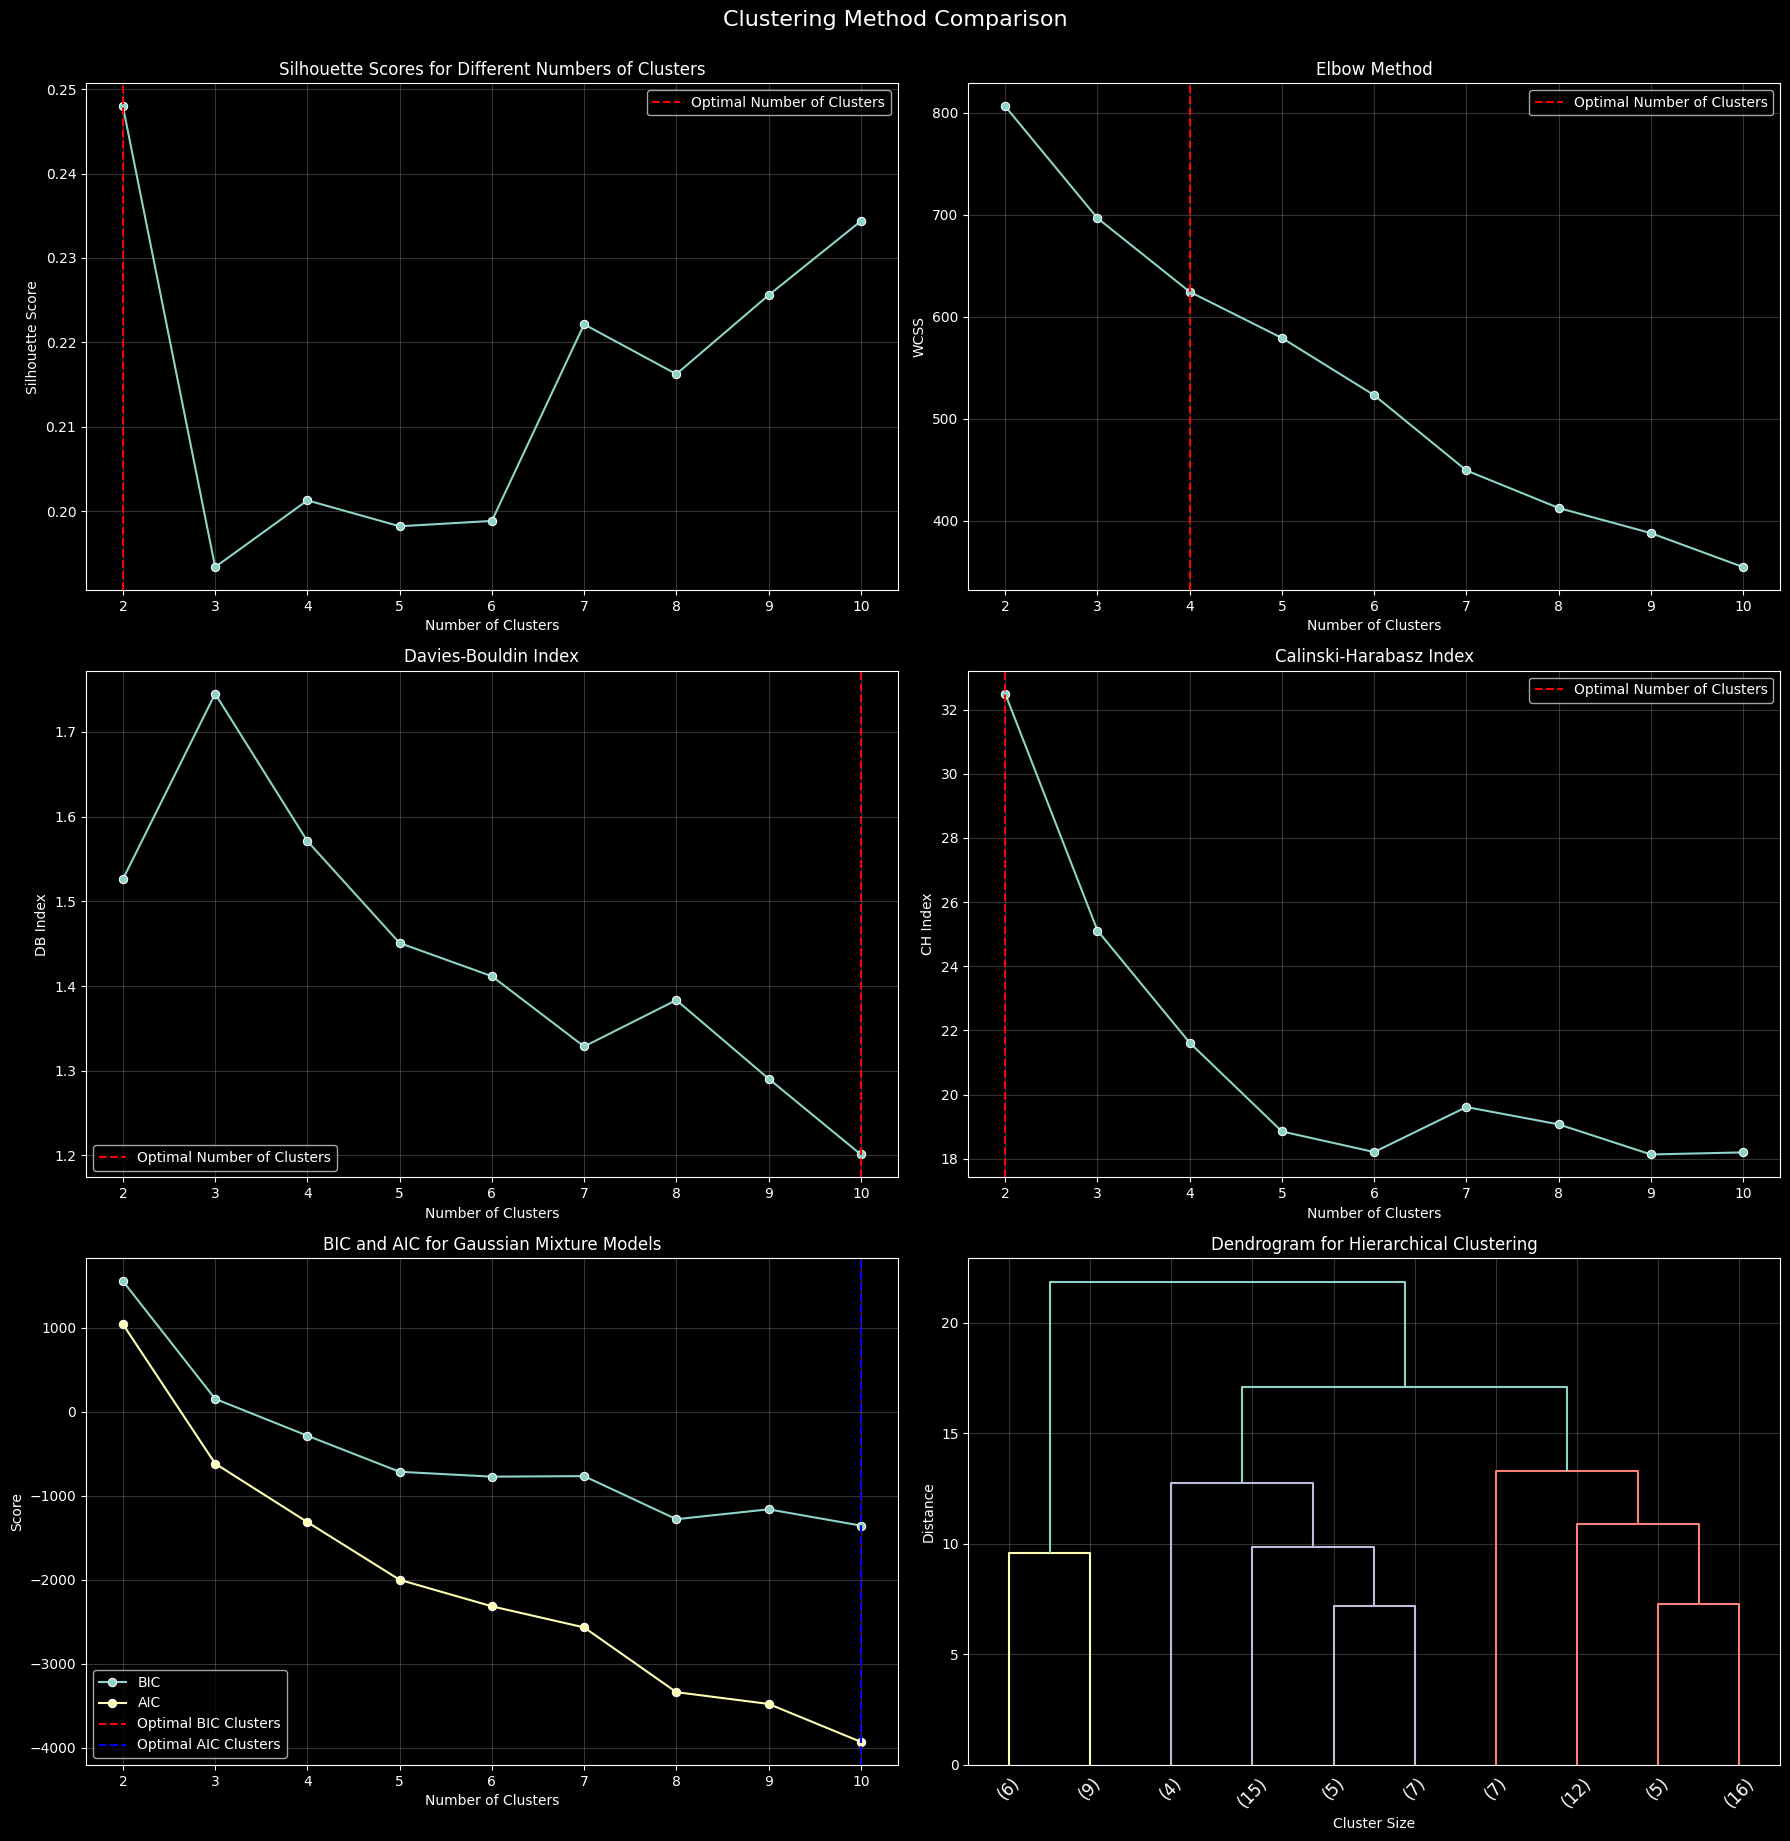

,Method,Optimal Number of Clusters
0,Silhouette,2
1,Elbow,4
2,Davies-Bouldin,10
3,Calinski-Harabasz,2
4,BIC,10
5,AIC,10
6,Hierarchical,1


In [15]:
# Compare methods to determine the optimal number of clusters
cluster_range = range(2, 11)  # Test cluster sizes from 2 to 10

# Create subplots for different clustering methods
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(18, 18))
axes = axes.flatten()

results = []

# silhouette score
silhouette_scores = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_data)
    silhouette_avg = silhouette_score(normalized_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

results.append(('Silhouette', cluster_range[np.argmax(silhouette_scores)]))

# Visualize silhouette scores
sns.lineplot(x=cluster_range, y=silhouette_scores, marker='o', ax=axes[0])
axes[0].set_title('Silhouette Scores for Different Numbers of Clusters')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Silhouette Score')
axes[0].grid(True, alpha=0.2)  # noqa: FBT003
# highlight the optimal number of clusters
axes[0].axvline(
    x=cluster_range[np.argmax(silhouette_scores)],
    color='red',
    linestyle='--',
    label='Optimal Number of Clusters',
)
axes[0].legend()

# Elbow Method
wcss = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(normalized_data)
    wcss.append(kmeans.inertia_)

elbow_point = cluster_range[np.argmax(np.diff(wcss, 2)) + 2]  # + 2 to adjust for the first two points
results.append(('Elbow', elbow_point))

# Visualize WCSS
sns.lineplot(x=cluster_range, y=wcss, marker='o', ax=axes[1])
axes[1].set_title('Elbow Method')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('WCSS')
axes[1].grid(True, alpha=0.2)  # noqa: FBT003
# highlight the elbow point
axes[1].axvline(x=elbow_point, color='red', linestyle='--', label='Optimal Number of Clusters')
axes[1].legend()

# Davies-Bouldin Index
db_scores = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_data)
    db_scores.append(davies_bouldin_score(normalized_data, cluster_labels))

results.append(('Davies-Bouldin', cluster_range[np.argmin(db_scores)]))

# Visualize Davies-Bouldin Index
sns.lineplot(x=cluster_range, y=db_scores, marker='o', ax=axes[2])
axes[2].set_title('Davies-Bouldin Index')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('DB Index')
axes[2].grid(True, alpha=0.2)  # noqa: FBT003
# highlight the optimal number of clusters
axes[2].axvline(x=cluster_range[np.argmin(db_scores)], color='red', linestyle='--', label='Optimal Number of Clusters')
axes[2].legend()

# Calinski-Harabasz Index
ch_scores = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_data)
    ch_scores.append(calinski_harabasz_score(normalized_data, cluster_labels))

results.append(('Calinski-Harabasz', cluster_range[np.argmax(ch_scores)]))

# Visualize Calinski-Harabasz Index
sns.lineplot(x=cluster_range, y=ch_scores, marker='o', ax=axes[3])
axes[3].set_title('Calinski-Harabasz Index')
axes[3].set_xlabel('Number of Clusters')
axes[3].set_ylabel('CH Index')
axes[3].grid(True, alpha=0.2)  # noqa: FBT003
# highlight the optimal number of clusters
axes[3].axvline(x=cluster_range[np.argmax(ch_scores)], color='red', linestyle='--', label='Optimal Number of Clusters')
axes[3].legend()

# BIC/AIC using Gaussian Mixture Models
bic_scores = []
aic_scores = []
for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(normalized_data)
    bic_scores.append(gmm.bic(normalized_data))
    aic_scores.append(gmm.aic(normalized_data))

results.append(('BIC', cluster_range[np.argmin(bic_scores)]))
results.append(('AIC', cluster_range[np.argmin(aic_scores)]))

# Visualize BIC and AIC
sns.lineplot(x=cluster_range, y=bic_scores, marker='o', label='BIC', ax=axes[4])
sns.lineplot(x=cluster_range, y=aic_scores, marker='o', label='AIC', ax=axes[4])
axes[4].set_title('BIC and AIC for Gaussian Mixture Models')
axes[4].set_xlabel('Number of Clusters')
axes[4].set_ylabel('Score')
axes[4].legend()
axes[4].grid(True, alpha=0.2)  # noqa: FBT003
# highlight the optimal number of clusters for BIC and AIC
axes[4].axvline(x=cluster_range[np.argmin(bic_scores)], color='red', linestyle='--', label='Optimal BIC Clusters')
axes[4].axvline(x=cluster_range[np.argmin(aic_scores)], color='blue', linestyle='--', label='Optimal AIC Clusters')
axes[4].legend()

# Dendrogram for Hierarchical Clustering
linked = linkage(normalized_data, method='ward')
dendrogram(
    linked,
    truncate_mode='lastp',
    p=10,
    leaf_rotation=45.0,
    leaf_font_size=12.0,
    show_contracted=True,
    ax=axes[5],
)

clusters = fcluster(linked, t=28, criterion='distance')
results.append(('Hierarchical', len(set(clusters))))

# Visualize Dendrogram
axes[5].set_title('Dendrogram for Hierarchical Clustering')
axes[5].set_xlabel('Cluster Size')
axes[5].set_ylabel('Distance')
axes[5].grid(True, alpha=0.2)  # noqa: FBT003

plt.tight_layout()
plt.suptitle('Clustering Method Comparison', size=16, y=1.02)
plt.show()

# Display clustering results
results_df = pd.DataFrame(results, columns=['Method', 'Optimal Number of Clusters'])
# make results integers
results_df['Optimal Number of Clusters'] = results_df['Optimal Number of Clusters'].astype(int)
display(results_df)


Optimal number of clusters determined by majority vote: 10
Cluster counts:
cluster
0    14
1     7
2     5
3    20
4    11
5    12
6     4
7     7
8     2
9     4
Name: count, dtype: int64


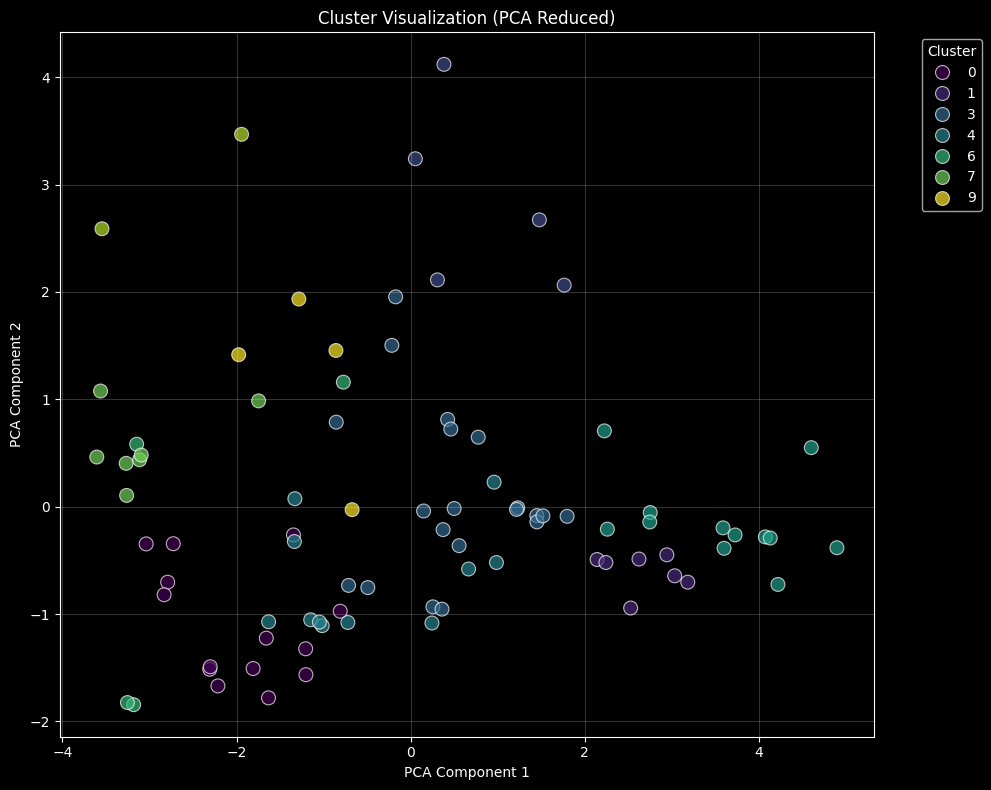

Cluster 0 Members:


,id,year,cluster
0,0,1258,0
4,4,1296,0
14,14,1317,0
19,19,1348,0
24,24,1348,0
30,30,1349,0
32,32,1349,0
33,33,1350,0
36,36,1359,0
56,56,1401,0


Cluster 1 Members:


,id,year,cluster
7,7,1297,1
16,16,1336,1
18,18,1347,1
22,22,1348,1
28,28,1348,1
38,38,1361,1
39,39,1361,1


Cluster 2 Members:


,id,year,cluster
26,26,1348,2
50,50,1397,2
51,51,1397,2
75,75,1412,2
76,76,1412,2


Cluster 3 Members:


,id,year,cluster
1,1,1278,3
5,5,1296,3
9,9,1297,3
10,10,1298,3
15,15,1324,3
23,23,1348,3
27,27,1348,3
29,29,1348,3
31,31,1349,3
35,35,1359,3


Cluster 4 Members:


,id,year,cluster
20,20,1348,4
25,25,1348,4
46,46,1395,4
57,57,1405,4
59,59,1405,4
60,60,1405,4
64,64,1407,4
65,65,1409,4
79,79,1420,4
82,82,1433,4


Cluster 5 Members:


,id,year,cluster
2,2,1295,5
11,11,1315,5
37,37,1360,5
40,40,1373,5
43,43,1391,5
52,52,1397,5
54,54,1400,5
58,58,1405,5
68,68,1410,5
70,70,1410,5


Cluster 6 Members:


,id,year,cluster
34,34,1350,6
41,41,1387,6
45,45,1395,6
78,78,1420,6


Cluster 7 Members:


,id,year,cluster
3,3,1295,7
6,6,1297,7
8,8,1297,7
12,12,1315,7
13,13,1315,7
48,48,1396,7
61,61,1405,7


Cluster 8 Members:


,id,year,cluster
17,17,1346,8
53,53,1399,8


Cluster 9 Members:


,id,year,cluster
21,21,1348,9
47,47,1396,9
55,55,1400,9
83,83,1434,9


In [16]:
# optimal number of clusters as the mode of the optimal clusters from different methods
optimal_clusters = results_df['Optimal Number of Clusters'].mode()[0]
print(f'Optimal number of clusters determined by majority vote: {optimal_clusters}')

# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(normalized_data)

# Display the number of records in each cluster
cluster_counts = df['cluster'].value_counts().sort_index()
print('Cluster counts:')
print(cluster_counts)

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)
df['pca_x'] = reduced_data[:, 0]
df['pca_y'] = reduced_data[:, 1]

# Scatter plot of clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='pca_x', y='pca_y', hue='cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Cluster Visualization (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.2)  # noqa: FBT003
plt.tight_layout()
plt.show()

# Display cluster members as a table
for cluster_id in sorted(df['cluster'].unique()):
    cluster_members = df[df['cluster'] == cluster_id]
    print(f'Cluster {cluster_id} Members:')
    display(cluster_members[['id', 'year', 'cluster']])


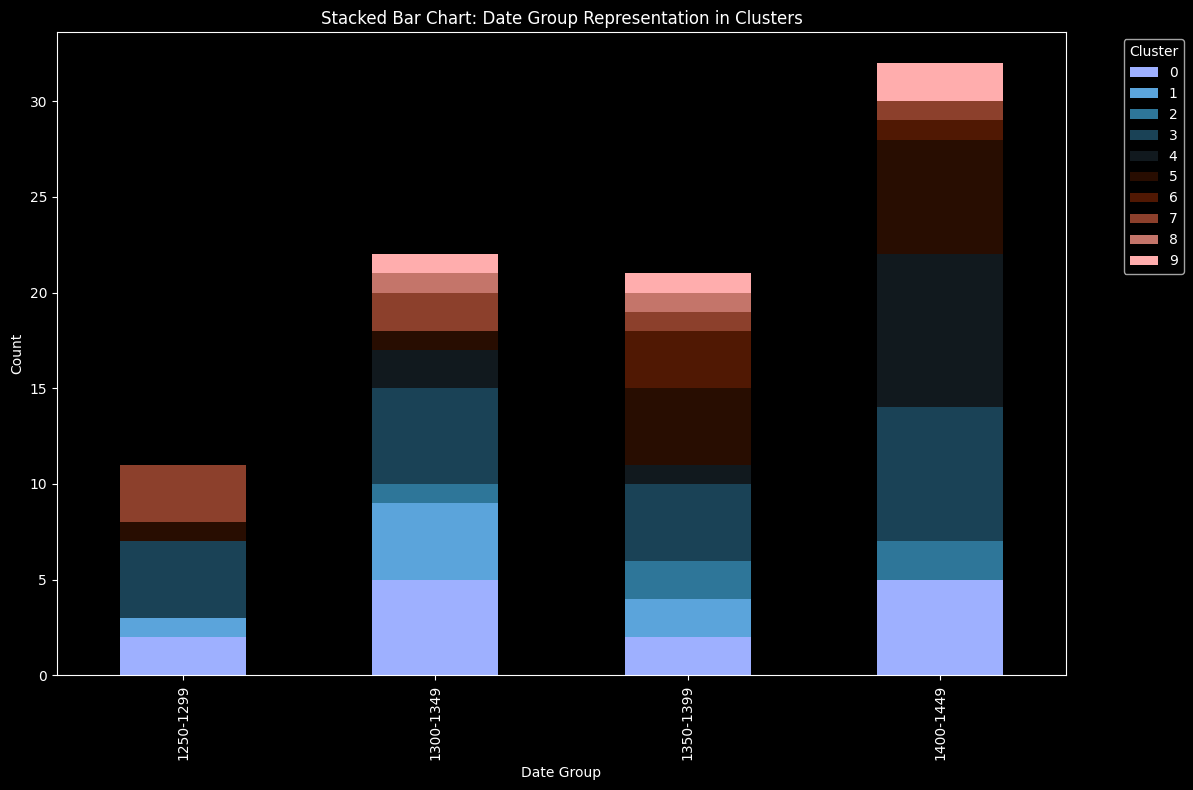

Date Group Distribution Across Clusters:


date_group,1250-1299,1300-1349,1350-1399,1400-1449
cluster,,,,
0,2,5,2,5
1,1,4,2,0
2,0,1,2,2
3,4,5,4,7
4,0,2,1,8
5,1,1,4,6
6,0,0,3,1
7,3,2,1,1
8,0,1,1,0


In [17]:
# Analyze date group representation in each cluster
date_group_distribution = df.groupby(['cluster', 'date_group']).size().unstack(fill_value=0)

# Stacked Bar Chart
date_group_distribution.T.plot(kind='bar', stacked=True, colormap='berlin', figsize=(12, 8))
plt.title('Stacked Bar Chart: Date Group Representation in Clusters')
plt.xlabel('Date Group')
plt.ylabel('Count')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print the distribution as a table
print('Date Group Distribution Across Clusters:')
display(date_group_distribution)